# 6DoF Pose Estimation with Ultrasound Frames and IMU Data


## 1. Import Libraries


In [1]:
import logging
import math
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import yaml
from natsort import natsorted
from neuralop.models import FNO1d
from rich.console import Console
from rich.logging import RichHandler
from scipy.linalg import orthogonal_procrustes
from scipy.spatial.transform import Rotation
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from models.kan import KAN

## 2. Configuration


In [2]:
# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Configuration values
CONFIG_PATH = "configs/default_config.yaml"
SCAN_DIR = "scans/wrist/"
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
NUMERIC_COLUMNS = [
    "ot_pos_x",
    "ot_pos_y",
    "ot_pos_z",
    "ot_qw",
    "ot_qx",
    "ot_qy",
    "ot_qz",
    "imu_acc_x",
    "imu_acc_y",
    "imu_acc_z",
    "imu_orientation_x",
    "imu_orientation_y",
    "imu_orientation_z",
]
SEQUENCE_LENGTH = 2
DOWNSAMPLE_FACTOR = 3
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VAL = 1
NUM_EPOCHS = 100000
LEARNING_RATE = 0.0005
PATIENCE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RECONSTRUCTION_VOXEL_SIZE = 0.1
PLOT_FRAME_STRIDE = 1
PLOT_SCALE = 0.1
MODEL_SAVE_DIR = "experiments/checkpoints/"
OT_TRANSLATION_SCALE = 1.0
OT_ROTATION_SCALE = 1.0
IMU_ACC_SCALE = 100.0
IMU_ORIENTATION_SCALE = 100.0
IMU_ALIGN = False
SAMPLING_RATE = 10
PROBE_SPECS = {"depth": 50, "width": 38, "marker_to_probe_bottom": 54}

In [3]:
# Automatically detect the terminal width
# terminal_width = shutil.get_terminal_size((80, 20)).columns

# Set the console width to the detected terminal width
console = Console(force_jupyter=True)

logging.basicConfig(level="INFO", handlers=[RichHandler()])
logger = logging.getLogger("rich")

# Set logging level for external libraries to WARNING or higher
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("font_manager").setLevel(logging.WARNING)

In [4]:
def load_config(config_path):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

In [5]:
config = load_config(CONFIG_PATH)

## 3. Dataset Class


In [6]:
class ProbePoseDataset(Dataset):
    def __init__(
        self,
        dfs,
        sequence_length=SEQUENCE_LENGTH,
        downsample_factor=DOWNSAMPLE_FACTOR,
        ot_translation_scale=OT_TRANSLATION_SCALE,
        ot_rotation_scale=OT_ROTATION_SCALE,
        imu_acc_scale=IMU_ACC_SCALE,
        imu_orientation_scale=IMU_ORIENTATION_SCALE,
        use_aligned_data=IMU_ALIGN,
        mode="absolute",
    ):
        self.sequence_length = sequence_length
        self.downsample_factor = downsample_factor
        self.ot_translation_scale = float(ot_translation_scale)
        self.ot_rotation_scale = float(ot_rotation_scale)
        self.imu_acc_scale = float(imu_acc_scale)
        self.imu_orientation_scale = float(imu_orientation_scale)
        self.use_aligned_data = use_aligned_data
        self.sequences = []
        self.mode = mode

        for df in dfs:
            logger.debug(f"processing data: {df}")
            reference_row = df.iloc[0]
            if self.mode == "absolute":
                reference_position = [
                    reference_row["ot_pos_x"],
                    reference_row["ot_pos_y"],
                    reference_row["ot_pos_z"],
                ]

                reference_orientation = Rotation.from_quat(
                    [
                        reference_row["ot_qx"],
                        reference_row["ot_qy"],
                        reference_row["ot_qz"],
                        reference_row["ot_qw"],
                    ]
                )

                df["ot_pos_x"] = df["ot_pos_x"] - reference_position[0]
                df["ot_pos_y"] = df["ot_pos_y"] - reference_position[1]
                df["ot_pos_z"] = df["ot_pos_z"] - reference_position[2]

                euler_angles = (
                    df.loc[:, ["ot_qx", "ot_qy", "ot_qz", "ot_qw"]]
                    .apply(
                        lambda row: Rotation.from_quat(
                            [row["ot_qx"], row["ot_qy"], row["ot_qz"], row["ot_qw"]]
                        ),
                        axis=1,
                    )
                    .apply(lambda row: reference_orientation.inv() * row)
                    .apply(lambda row: row.as_euler("xyz"))
                )
                df["ot_euler_x"] = euler_angles.apply(lambda row: row[0])
                df["ot_euler_y"] = euler_angles.apply(lambda row: row[1])
                df["ot_euler_z"] = euler_angles.apply(lambda row: row[2])

                logger.debug(f"prepared absolute data: {df}")

            for row in df[
                ["ot_cumulative_x", "ot_cumulative_y", "ot_cumulative_z"]
            ].itertuples():
                if row[1] == 0 and row[2] == 0 and row[3] == 0:
                    continue
                first_nonzero_idx = row[0]
                break
            df = df.iloc[first_nonzero_idx - 1 :]
            df = df.reset_index(drop=True)
            logger.debug(f"zero trimmed data: {df}")

            cutoff_idx = self.find_cutoff_index(df)
            df_truncated = df.iloc[:cutoff_idx].reset_index(drop=True)
            self.generate_sequences(df_truncated)

    def generate_sequences(self, df):
        logger.debug(f"generating sequences for data: {df}")
        for i in range(len(df) - self.sequence_length + 1):
            self.sequences.append(df.iloc[i : i + self.sequence_length])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        frames = torch.stack(
            [
                self.load_and_process_frame(row["frame"])
                for _, row in sequence.iterrows()
            ]
        )
        imu_data = torch.stack(
            [self.get_imu_data(row) for _, row in sequence.iterrows()]
        )

        if self.mode == "absolute":
            position = torch.tensor(
                [
                    sequence.iloc[-1]["ot_pos_x"],
                    sequence.iloc[-1]["ot_pos_y"],
                    sequence.iloc[-1]["ot_pos_z"],
                ]
            ).float()
            orientation_euler = torch.tensor(
                [
                    sequence.iloc[-1]["ot_euler_x"],
                    sequence.iloc[-1]["ot_euler_y"],
                    sequence.iloc[-1]["ot_euler_z"],
                ]
            ).float()
            target = torch.cat((position, orientation_euler))

        else:
            raise ValueError(f"Unsupported mode: {self.mode}")

        return frames, imu_data, target

    def find_cutoff_index(self, df):
        total_rows = len(df)
        start_idx = total_rows // 3
        end_idx = 2 * total_rows // 3
        middle_df = df.iloc[start_idx:end_idx]
        logger.debug(f"middle df: {middle_df}")

        linear_displacements = (
            middle_df.loc[:, ["ot_pos_x", "ot_pos_y", "ot_pos_z"]]
            .diff()
            .apply(lambda row: row.apply(lambda x: x**2).sum(), axis=1)
            .apply(lambda x: math.sqrt(x))
        )
        logger.debug(f"linear displacements: {linear_displacements}")
        rotations = middle_df.loc[:, ["ot_qx", "ot_qy", "ot_qz", "ot_qw"]].apply(
            lambda row: Rotation.from_quat(
                [row["ot_qx"], row["ot_qy"], row["ot_qz"], row["ot_qw"]]
            ),
            axis=1,
        )
        logger.debug(f"rotations: {rotations}")

        relative_rotations = []
        for row_idx in range(1, len(rotations)):
            q1 = rotations.iloc[row_idx - 1]
            q2 = rotations.iloc[row_idx]
            delta_rotation = q2 * q1.inv()
            relative_rotations.append(delta_rotation.magnitude())

        angular_displacements = np.array(relative_rotations)

        logger.debug(f"angular displacements: {angular_displacements}")

        mean_linear = linear_displacements.mean()
        std_linear = linear_displacements.std()
        mean_angular = angular_displacements.mean()
        std_angular = angular_displacements.std()
        logger.debug(f"mean linear displacement: {mean_linear}, std: {std_linear}")
        logger.debug(f"mean angular displacement: {mean_angular}, std: {std_angular}")

        for idx in range(end_idx, total_rows):
            linear_disp = (
                (df["ot_pos_x"].iloc[idx] - df["ot_pos_x"].iloc[idx - 1]) ** 2
                + (df["ot_pos_y"].iloc[idx] - df["ot_pos_y"].iloc[idx - 1]) ** 2
                + (df["ot_pos_z"].iloc[idx] - df["ot_pos_z"].iloc[idx - 1]) ** 2
            ) ** 0.5

            q1 = Rotation.from_quat(
                df.loc[idx - 1, ["ot_qx", "ot_qy", "ot_qz", "ot_qw"]]
            )
            q2 = Rotation.from_quat(df.loc[idx, ["ot_qx", "ot_qy", "ot_qz", "ot_qw"]])
            delta_rotation = q2 * q1.inv()
            angular_disp = delta_rotation.magnitude()
            if (
                linear_disp > mean_linear + 1 * std_linear
                or angular_disp > mean_angular + 1 * std_angular
            ):
                logger.debug(
                    f"found cutoff index: {idx}, linear: {linear_disp}, angular: {angular_disp}"
                )
                return idx

        return total_rows

    def get_imu_data(self, row):
        if self.use_aligned_data:
            assert "imu_acc_x_aligned" in row
            acc_x = row["imu_acc_x_aligned"]
            acc_y = row["imu_acc_y_aligned"]
            acc_z = row["imu_acc_z_aligned"]
        else:
            acc_x = row["imu_acc_x"]
            acc_y = row["imu_acc_y"]
            acc_z = row["imu_acc_z"]

        imu_data = np.array(
            [
                acc_x,
                acc_y,
                acc_z,
                row["imu_orientation_x"],
                row["imu_orientation_y"],
                row["imu_orientation_z"],
            ]
        )

        if imu_data.shape != (6,):
            raise ValueError(
                f"Invalid IMU data shape: expected (6,), got {imu_data.shape}"
            )

        return torch.tensor(imu_data).float()

    def load_and_process_frame(self, frame):
        frame = torch.tensor(np.stack(frame)).float().permute(2, 0, 1)
        if frame.max() > 1:
            frame = frame / 255.0
        if self.downsample_factor > 1:
            frame = F.resize(
                frame, [dim // self.downsample_factor for dim in frame.shape[1:]]
            )
        return frame

## 4. Custom Loss


In [7]:
class CombinedLoss(nn.Module):
    def __init__(self, loss_config):
        super(CombinedLoss, self).__init__()
        self.loss_config = loss_config
        self.losses = {
            "L1": nn.L1Loss(),
            "L2": nn.MSELoss(),
            "Smoothness": self.smoothness_loss,
            "Geodesic": self.geodesic_loss,
            "KineticEnergy": self.kinetic_energy_loss,
            "TemporalConsistency": self.temporal_consistency_loss,
            "InverseDynamics": self.inverse_dynamics_loss,
            # Add more loss functions as needed
        }

    def forward(self, predictions, targets, inputs=None):
        total_loss = 0.0
        for loss_name, weight in self.loss_config.items():
            if loss_name in self.losses:
                loss_func = self.losses[loss_name]
                if loss_name == "InverseDynamics":
                    loss_value = loss_func(predictions, targets, inputs)
                else:
                    loss_value = loss_func(predictions, targets)
                total_loss += weight * loss_value
        return total_loss

    def smoothness_loss(self, predictions, targets):
        diff = predictions[:, 1:] - predictions[:, :-1]
        smoothness = torch.mean(torch.abs(diff))
        return smoothness

    def geodesic_loss(self, predictions, targets):
        pred_rot = torch.Tensor(predictions[:, 3:])
        target_rot = torch.Tensor(targets[:, 3:])
        geodesic_dist = torch.acos(
            torch.clamp(torch.sum(pred_rot * target_rot, dim=-1), -1 + 1e-6, 1 - 1e-6)
        )
        return torch.mean(geodesic_dist)

    def kinetic_energy_loss(self, predictions, targets):
        # Kinetic energy loss using velocity derived from predictions and mass m=1
        velocity = predictions[
            :, :3
        ]  # Assume velocity is predicted as part of linear displacement
        ke = 0.5 * torch.sum(velocity**2, dim=1)
        return torch.mean(ke)

    def temporal_consistency_loss(self, predictions, targets):
        # Temporal consistency loss to ensure smooth transitions between frames
        diff_pred = predictions[:, 1:, :] - predictions[:, :-1, :]
        diff_target = targets[:, 1:, :] - targets[:, :-1, :]
        temporal_consistency = torch.mean(torch.abs(diff_pred - diff_target))
        return temporal_consistency

    def inverse_dynamics_loss(self, predictions, targets, inputs):
        # Inverse dynamics loss using IMU acceleration and orientation as inputs
        # Compute predicted displacements from inputs and compare with actual predictions
        imu_acc = inputs["imu_acc"]
        imu_orient = inputs["imu_orient"]

        # Assuming predictions contain linear displacements and angular displacements
        predicted_linear_displacement = predictions[:, :3]
        predicted_angular_displacement = predictions[:, 3:]

        # Inverse dynamics: compute expected displacement from acceleration (integrate once)
        expected_linear_displacement = 0.5 * torch.cumsum(imu_acc, dim=1)

        # Penalize the difference between predicted and expected displacements
        linear_loss = F.mse_loss(
            predicted_linear_displacement, expected_linear_displacement
        )

        # Compute expected rotation from angular velocities (simple model for now)
        expected_angular_displacement = (
            imu_orient  # Placeholder; requires more sophisticated modeling
        )
        angular_loss = F.mse_loss(
            predicted_angular_displacement, expected_angular_displacement
        )

        return linear_loss + angular_loss

## 5. Utility Functions


In [8]:
def load_data(directory_path, align=False):
    directory = Path(directory_path)
    file_paths = natsorted(directory.glob("*.h5"))
    dfs = [(file_path, pd.read_hdf(file_path)) for file_path in file_paths]
    dfs = [(df[0], preprocess_and_align_dataframe(df[1], align=align)) for df in dfs]

    logger.info("Loaded and preprocessed the following files:")
    for file in file_paths:
        console.print(f"[green]{file}[/green]")

    return dfs


def preprocess_and_align_dataframe(df, align=False):
    df["imu_acc_x"] = df["imu_acc_x"] * IMU_ACC_SCALE
    df["imu_acc_y"] = df["imu_acc_y"] * IMU_ACC_SCALE
    df["imu_acc_z"] = df["imu_acc_z"] * IMU_ACC_SCALE
    df["imu_orientation_x"] = df["imu_orientation_x"] * IMU_ORIENTATION_SCALE
    df["imu_orientation_y"] = df["imu_orientation_y"] * IMU_ORIENTATION_SCALE
    df["imu_orientation_z"] = df["imu_orientation_z"] * IMU_ORIENTATION_SCALE

    displacements = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].diff().fillna(0)
    df["ot_cumulative_x"] = displacements["ot_pos_x"].cumsum()
    df["ot_cumulative_y"] = displacements["ot_pos_y"].cumsum()
    df["ot_cumulative_z"] = displacements["ot_pos_z"].cumsum()

    rotations = Rotation.from_quat(df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values)
    relative_rotations = rotations[1:] * rotations[:-1].inv()
    angular_displacements = relative_rotations.as_euler("xyz")
    # prepend a zero row to match the length of the original dataframe
    angular_displacements = np.vstack((np.zeros(3), angular_displacements))

    df["ot_cumulative_rot_x"] = np.cumsum(angular_displacements[:, 0])
    df["ot_cumulative_rot_y"] = np.cumsum(angular_displacements[:, 1])
    df["ot_cumulative_rot_z"] = np.cumsum(angular_displacements[:, 2])

    dt = 1 / SAMPLING_RATE
    df["imu_cumulative_x"] = np.cumsum(df["imu_acc_x"] * dt * dt)
    df["imu_cumulative_y"] = np.cumsum(df["imu_acc_y"] * dt * dt)
    df["imu_cumulative_z"] = np.cumsum(df["imu_acc_z"] * dt * dt)

    if align:
        ot_data = df[["ot_cumulative_x", "ot_cumulative_y", "ot_cumulative_z"]].values
        imu_data = df[
            ["imu_cumulative_x", "imu_cumulative_y", "imu_cumulative_z"]
        ].values

        ot_data_norm = (ot_data - np.mean(ot_data, axis=0)) / np.std(ot_data)
        imu_data_norm = (imu_data - np.mean(imu_data, axis=0)) / np.std(imu_data)

        R, _ = orthogonal_procrustes(imu_data_norm, ot_data_norm)

        imu_acc_aligned = np.dot(df[["imu_acc_x", "imu_acc_y", "imu_acc_z"]], R.T)

        df["imu_acc_x_aligned"] = imu_acc_aligned[:, 0]
        df["imu_acc_y_aligned"] = imu_acc_aligned[:, 1]
        df["imu_acc_z_aligned"] = imu_acc_aligned[:, 2]

    return df


def visualize_trajectories_and_errors(df, aligned=False):
    fig = plt.figure(figsize=(20, 15))

    # Plot OT Data
    ax1 = fig.add_subplot(441, projection="3d")
    ax1.plot(df["ot_cumulative_x"], df["ot_cumulative_y"], df["ot_cumulative_z"])
    ax1.set_title("Cumulative OT Trajectory")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    ax2 = fig.add_subplot(442)
    ax2.plot(df["ot_cumulative_x"], label="X")
    ax2.plot(df["ot_cumulative_y"], label="Y")
    ax2.plot(df["ot_cumulative_z"], label="Z")
    ax2.set_title("Cumulative OT Translation")
    ax2.legend()

    ax3 = fig.add_subplot(443)
    ot_rotations = Rotation.from_quat(df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values)
    ot_euler = ot_rotations.as_euler("xyz", degrees=True)
    ax3.plot(ot_euler[:, 0], label="Roll")
    ax3.plot(ot_euler[:, 1], label="Pitch")
    ax3.plot(ot_euler[:, 2], label="Yaw")
    ax3.set_title("Cumulative OT Rotation")
    ax3.legend()

    ax4 = fig.add_subplot(444, projection="3d")
    ax4.plot(df["ot_pos_x"], df["ot_pos_y"], df["ot_pos_z"])
    ax4.set_title("Absolute OT Trajectory")
    ax4.set_xlabel("X")
    ax4.set_ylabel("Y")
    ax4.set_zlabel("Z")

    # Plot IMU Data
    ax5 = fig.add_subplot(445, projection="3d")
    ax5.plot(df["imu_cumulative_x"], df["imu_cumulative_y"], df["imu_cumulative_z"])
    ax5.set_title(f'Cumulative IMU Trajectory {"(Aligned)" if aligned else ""}')
    ax5.set_xlabel("X")
    ax5.set_ylabel("Y")
    ax5.set_zlabel("Z")

    ax6 = fig.add_subplot(446)
    ax6.plot(df["imu_cumulative_x"], label="X")
    ax6.plot(df["imu_cumulative_y"], label="Y")
    ax6.plot(df["imu_cumulative_z"], label="Z")
    ax6.set_title(f'Cumulative IMU Translation {"(Aligned)" if aligned else ""}')
    ax6.legend()

    ax7 = fig.add_subplot(447)
    ax7.plot(df["imu_orientation_x"], label="Roll")
    ax7.plot(df["imu_orientation_y"], label="Pitch")
    ax7.plot(df["imu_orientation_z"], label="Yaw")
    ax7.set_title(f'Cumulative IMU Rotation {"(Aligned)" if aligned else ""}')
    ax7.legend()

    ax8 = fig.add_subplot(448)
    ax8.plot(df["ot_cumulative_x"] - df["imu_cumulative_x"], label="X Error")
    ax8.plot(df["ot_cumulative_y"] - df["imu_cumulative_y"], label="Y Error")
    ax8.plot(df["ot_cumulative_z"] - df["imu_cumulative_z"], label="Z Error")
    ax8.set_title("Error: Cumulative OT - Cumulative IMU")
    ax8.legend()

    plt.tight_layout()
    plt.show()


def compare_original_and_aligned_data(df):
    if "imu_acc_x_aligned" in df.columns:
        fig, axes = plt.subplots(3, 1, figsize=(12, 15))
        for i, axis in enumerate(["x", "y", "z"]):
            axes[i].plot(df[f"imu_acc_{axis}"], label="Original")
            axes[i].plot(df[f"imu_acc_{axis}_aligned"], label="Aligned")
            axes[i].set_title(f"IMU Acceleration {axis.upper()}")
            axes[i].legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No aligned data found in the DataFrame")


def split_dataset(dfs, val_size, test_size):
    num_files = len(dfs)

    if num_files < 3:
        raise ValueError(f"Not enough files to split. Found only {num_files} file(s).")

    num_test_files = max(1, math.ceil(num_files * test_size))
    num_val_files = max(1, math.ceil(num_files * val_size))
    num_train_files = num_files - num_test_files - num_val_files

    if num_train_files < 1:
        raise ValueError(
            f"Not enough files for training. Adjust val_size and test_size."
        )

    train_tuples = dfs[:num_train_files]
    val_tuples = dfs[num_train_files : num_train_files + num_val_files]
    test_tuples = dfs[num_train_files + num_val_files :]

    logger.info(f"Total files: {num_files}")
    logger.info(
        f"Training files: {len(train_tuples)}, Validation files: {len(val_tuples)}, Test files: {len(test_tuples)}"
    )

    split_paths = {
        "train": [df[0] for df in train_tuples],
        "val": [df[0] for df in val_tuples],
        "test": [df[0] for df in test_tuples],
    }

    split_dataframes = {
        "train": [df[1] for df in train_tuples],
        "val": [df[1] for df in val_tuples],
        "test": [df[1] for df in test_tuples],
    }

    train_dataset = ProbePoseDataset(split_dataframes["train"])
    val_dataset = ProbePoseDataset(split_dataframes["val"])
    test_dataset = ProbePoseDataset(split_dataframes["test"])

    return train_dataset, val_dataset, test_dataset, split_paths


def create_data_loaders(
    train_dataset, val_dataset, test_dataset, batch_size_train, batch_size_val
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False)

    logger.info(
        f"Training samples: {len(train_loader.dataset)}, Validation samples: {len(val_loader.dataset)}, Test samples: {len(test_loader.dataset)}"
    )

    return train_loader, val_loader, test_loader

## 6. Model Definition


In [9]:
class TemporalAttentionProcessor(nn.Module):
    def __init__(self, hidden_dim, n_heads=8):
        super(TemporalAttentionProcessor, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, num_heads=n_heads, batch_first=True
        )

    def forward(self, x):
        attn_out, _ = self.attention(x, x, x)
        return attn_out


class IMUProcessor(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, output_dim=6, n_modes_time=16):
        super(IMUProcessor, self).__init__()
        self.fno = FNO1d(
            n_modes_height=n_modes_time,
            hidden_channels=hidden_dim,
            in_channels=input_dim,
            out_channels=hidden_dim,
        )
        self.temporal_attention = TemporalAttentionProcessor(hidden_dim)
        self.kan = KAN([hidden_dim, 128, 64])
        self.fc = nn.Linear(64, output_dim)

    def forward(self, imu_data):
        fno_input = imu_data.permute(0, 2, 1)
        fno_out = self.fno(fno_input)
        fno_out_padded = fno_out.permute(0, 2, 1)
        attention_out = self.temporal_attention(fno_out_padded)
        final_output = attention_out[:, -1, :]
        kan_out = self.kan(final_output)
        pose_prediction = self.fc(kan_out)
        return pose_prediction

## 7. Training and Evaluation Functions


In [10]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for frames, imu_data, targets in val_loader:
            frames, imu_data, targets = (
                frames.to(DEVICE),
                imu_data.to(DEVICE),
                targets.to(DEVICE),
            )
            outputs = model(imu_data)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    return val_loss / len(val_loader)


def train_imu_processor(
    imu_processor,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
):
    best_val_loss = float("inf")
    counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        imu_processor.train()
        train_loss = 0.0
        train_progress = tqdm(train_loader, desc="Training", leave=False)

        for _, imu_data, targets in train_progress:
            imu_data, targets = imu_data.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = imu_processor(imu_data)
            loss = criterion(outputs, targets)
            logger.debug(f"Output: {outputs}, Target: {targets}, Loss: {loss.item()}")
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_progress.set_postfix({"Train Loss": train_loss / len(train_loader)})

        train_progress.close()

        val_loss = validate_model(imu_processor, val_loader, criterion)
        scheduler.step(val_loss)

        print(
            f"Epoch {epoch + 1} finished. Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(
                imu_processor.state_dict(), f"{MODEL_SAVE_DIR}/best_imu_processor.pth"
            )
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break


def reconstruct_ground_truth_volume(
    df, probe_specs, voxel_size=RECONSTRUCTION_VOXEL_SIZE
):
    frames = df["frame"].values
    positions = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].values
    orientations = df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values

    depth = probe_specs["depth"]
    width = probe_specs["width"]
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]

    axial_scale = depth / 1000
    lateral_scale = width / 657

    rotations = Rotation.from_quat(orientations[:, [1, 2, 3, 0]])

    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )

    transform_matrix = np.array(
        [
            [0, 0, -1],
            [1, 0, 0],
            [0, -1, 0],
        ]
    )

    frame_corners = frame_corners @ transform_matrix.T
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = (
        np.einsum("ijk,lk->ilj", rotations.as_matrix(), frame_corners)
        + positions[:, np.newaxis, :]
    )
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    x, y = np.meshgrid(np.arange(657) * lateral_scale, np.arange(1000) * axial_scale)
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    frame_centers = []
    frame_orientations = []

    print("Reconstructing ground truth volume...")
    for i, (frame, position, orientation) in enumerate(
        tqdm(zip(frames, positions, orientations), total=len(frames))
    ):
        frame = np.mean(frame, axis=-1).astype(np.float32)

        rotation = Rotation.from_quat(orientation[[1, 2, 3, 0]]).as_matrix()
        world_coords = np.einsum("ij,klj->kli", rotation, frame_coords) + position

        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(
            np.int32
        )

        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

        frame_center = np.mean(all_corners[i], axis=0)
        frame_centers.append(frame_center)
        frame_orientations.append(orientation[[1, 2, 3, 0]])

    mask = counts > 0
    volume[mask] /= counts[mask]

    return (
        volume,
        min_corner,
        voxel_size,
        np.array(frame_centers),
        np.array(frame_orientations),
    )


def plot_frame_center_trajectories_with_error(
    gt_centers,
    gt_orientations,
    pred_centers,
    pred_orientations,
    frame_stride=PLOT_FRAME_STRIDE,
    scale=PLOT_SCALE,
):
    fig = plt.figure(figsize=(20, 6))

    ax1 = fig.add_subplot(131, projection="3d")
    plot_trajectory(
        ax1, gt_centers, gt_orientations, frame_stride, scale, "Ground Truth", "blue"
    )

    ax2 = fig.add_subplot(132, projection="3d")
    plot_trajectory(
        ax2, pred_centers, pred_orientations, frame_stride, scale, "Predicted", "red"
    )

    ax3 = fig.add_subplot(133)
    plot_trajectory_error(ax3, gt_centers, pred_centers)

    plt.tight_layout()
    plt.show()


def plot_trajectory(ax, centers, orientations, frame_stride, scale, title, color):
    ax.plot(
        centers[:, 0], centers[:, 1], centers[:, 2], label="Trajectory", color=color
    )

    for i in range(0, len(centers), frame_stride):
        pos = centers[i]
        quat = orientations[i]
        rot_matrix = Rotation.from_quat(quat).as_matrix()

        axes = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, scale]])
        transformed_axes = rot_matrix @ axes.T + pos[:, np.newaxis]

        colors = ["r", "g", "b"]
        labels = ["X", "Y", "Z"]
        for j, (axis_color, label) in enumerate(zip(colors, labels)):
            ax.quiver(
                pos[0],
                pos[1],
                pos[2],
                transformed_axes[0, j] - pos[0],
                transformed_axes[1, j] - pos[1],
                transformed_axes[2, j] - pos[2],
                color=axis_color,
                label=f"{label} axis" if i == 0 else "",
            )

    ax.set_xlabel("X Position (mm)")
    ax.set_ylabel("Y Position (mm)")
    ax.set_zlabel("Z Position (mm)")
    ax.set_title(f"{title} Frame Center Trajectory")
    ax.legend()


def plot_trajectory_error(ax, gt_centers, pred_centers):
    min_length = min(len(gt_centers), len(pred_centers))
    gt_centers_truncated = gt_centers[:min_length]
    pred_centers_truncated = pred_centers[:min_length]
    error = np.linalg.norm(pred_centers_truncated - gt_centers_truncated, axis=1)
    ax.plot(error, color="green")
    ax.set_title("Frame Center Position Error Over Time")
    ax.set_xlabel("Frame Index")
    ax.set_ylabel("Position Error (mm)")
    ax.grid(True)


def reconstruct_predicted_volume_displacement(
    frames,
    predicted_values,
    probe_specs,
    voxel_size=RECONSTRUCTION_VOXEL_SIZE,
    ot_translation_scale=OT_TRANSLATION_SCALE,
    ot_rotation_scale=OT_ROTATION_SCALE,
    initial_pose=None,
    mode="absolute",
):
    if initial_pose is None:
        current_position = np.zeros(3)
        current_rotation = np.eye(3)
    else:
        current_position, current_rotation = initial_pose

    depth = probe_specs["depth"]
    width = probe_specs["width"]
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]

    axial_scale = depth / frames.shape[1]
    lateral_scale = width / frames.shape[2]

    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )
    transform_matrix = np.array(
        [
            [0, 0, -1],
            [1, 0, 0],
            [0, -1, 0],
        ]
    )
    frame_corners = frame_corners @ transform_matrix.T
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = []
    positions = []

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    print("Reconstructing predicted volume...")

    for i, (frame, value) in enumerate(
        tqdm(zip(frames, predicted_values), total=len(frames))
    ):
        if mode == "incremental":
            translation = value[:3] / ot_translation_scale
            euler_angles = value[3:] / ot_rotation_scale
            quaternion = Rotation.from_euler("xyz", euler_angles).as_quat()
            rotation_matrix = Rotation.from_quat(quaternion).as_matrix()
            current_position += current_rotation @ translation
            current_rotation = current_rotation @ rotation_matrix
        elif mode == "absolute":
            current_position = value[:3] / ot_translation_scale
            euler_angles = value[3:] / ot_rotation_scale
            quaternion = Rotation.from_euler("xyz", euler_angles).as_quat()
            current_rotation = Rotation.from_quat(quaternion).as_matrix()
        else:
            raise ValueError(f"Unsupported mode: {mode}")

        corners_world = (
            np.einsum("ij,kj->ki", current_rotation, frame_corners) + current_position
        )
        all_corners.append(corners_world)
        positions.append(current_position.copy())

        for corner in corners_world:
            ax.scatter(
                corner[0],
                corner[1],
                corner[2],
                color="red",
                marker=".",
                label="Frame Corner" if i == 0 else "",
            )

    for j, corners in enumerate([all_corners[0], all_corners[-1]]):
        label = "Initial Frame" if j == 0 else "Final Frame"
        color = "blue" if j == 0 else "green"
        ax.plot(
            [corners[0][0], corners[1][0]],
            [corners[0][1], corners[1][1]],
            [corners[0][2], corners[1][2]],
            color=color,
            label=label if j == 0 else "",
        )
        ax.plot(
            [corners[1][0], corners[3][0]],
            [corners[1][1], corners[3][1]],
            [corners[1][2], corners[3][2]],
            color=color,
        )
        ax.plot(
            [corners[3][0], corners[2][0]],
            [corners[3][1], corners[2][1]],
            [corners[3][2], corners[2][2]],
            color=color,
        )
        ax.plot(
            [corners[2][0], corners[0][0]],
            [corners[2][1], corners[0][1]],
            [corners[2][2], corners[0][2]],
            color=color,
        )

    all_corners = np.array(all_corners)
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    x, y = np.meshgrid(
        np.arange(frames.shape[2]) * lateral_scale,
        np.arange(frames.shape[1]) * axial_scale,
    )
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    for i, frame in enumerate(tqdm(frames, total=len(frames))):
        if frame.ndim == 3:
            frame = np.mean(frame, axis=-1).astype(np.float32)

        world_coords = (
            np.einsum("ij,klj->kli", current_rotation, frame_coords) + current_position
        )
        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

    mask = counts > 0
    volume[mask] /= counts[mask]

    ax.set_xlabel("X Position (mm)")
    ax.set_ylabel("Y Position (mm)")
    ax.set_zlabel("Z Position (mm)")
    ax.set_title("Probe Position and Frame Corners Over Time")
    ax.legend()
    plt.show()

    return volume, min_corner, voxel_size


def inference_and_prediction(val_loader, model):
    all_frames = []
    all_predictions = []

    with torch.no_grad():
        for frames, imu_data, _ in val_loader:
            frames = frames.to(DEVICE)
            imu_data = imu_data.to(DEVICE)
            outputs = model(imu_data)

            all_frames.append(frames.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())

    all_frames = np.concatenate(all_frames, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    return all_frames, all_predictions

## 8. Main Execution


[09/12/24 14:10:16] INFO     INFO:rich:Loaded and preprocessed the following files:                 ]8;id=779396;file:///tmp/ipykernel_2075088/1105059061.py\1105059061.py]8;;\:]8;id=443376;file:///tmp/ipykernel_2075088/1105059061.py#7\7]8;;\

scans/wrist/wrist1_na_2608.h5

scans/wrist/wrist1_vs_2608.h5

scans/wrist/wrist1_yx_2608.h5

scans/wrist/wrist2_na_2608.h5

scans/wrist/wrist2_yx_2608.h5

Loading Data:   0%|          | 0/5 [00:00<?, ?it/s]

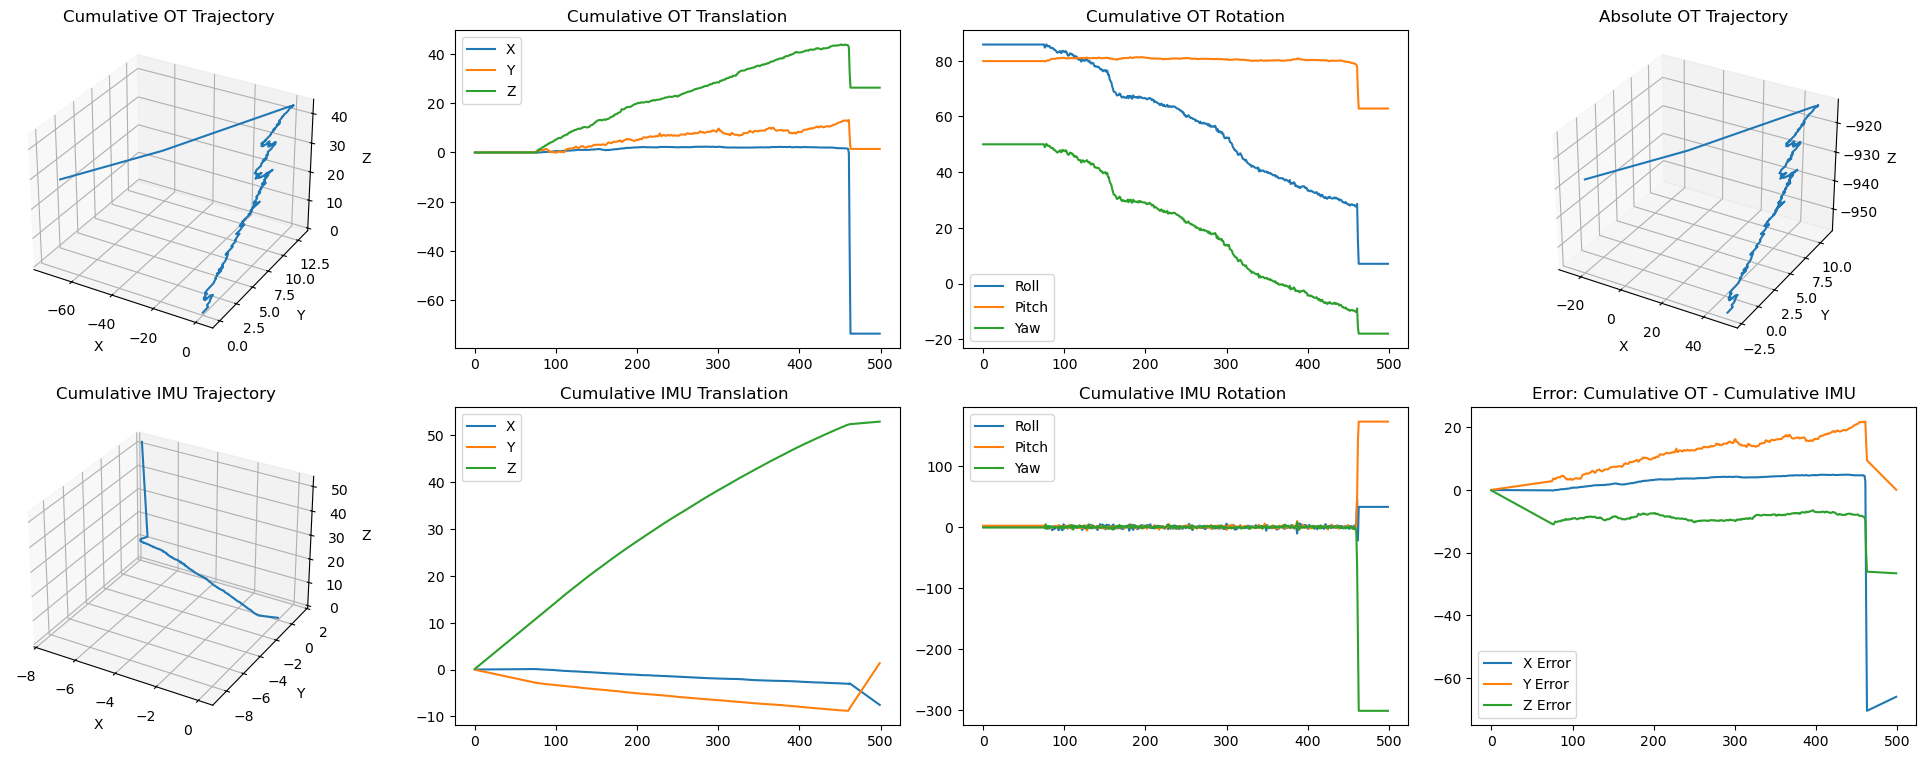

[09/12/24 14:10:17] INFO     INFO:rich:Loaded data from scans/wrist/wrist1_na_2608.h5               ]8;id=876257;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=406398;file:///tmp/ipykernel_2075088/2834228533.py#6\6]8;;\

                    INFO     INFO:rich:columns: Index(['timestamp', 'frame', 'imu_acc_x',           ]8;id=150501;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=147261;file:///tmp/ipykernel_2075088/2834228533.py#7\7]8;;\
                             'imu_acc_y', 'imu_acc_z',                                                             
                                    'imu_orientation_x', 'imu_orientation_y', 'imu_orientation_z',                 
                                    'ot_pos_x', 'ot_pos_y', 'ot_pos_z', 'ot_qw', 'ot_qx', 'ot_qy',                 
                             'ot_qz',                                                                              
                                    'ot_cumulative_x', 'ot_cumulative_y', 'ot_cumulative_z',                       
                                    'ot_cumulative_rot_x', 'ot_cumulative_rot_y',                                  
                             'ot_cumulative_rot_z',                                                                
                                    'imu_cumulative_x', 'imu_cumulative_y', 'imu_cumulative_z'],                   
                                   dtype='object')                                                                 

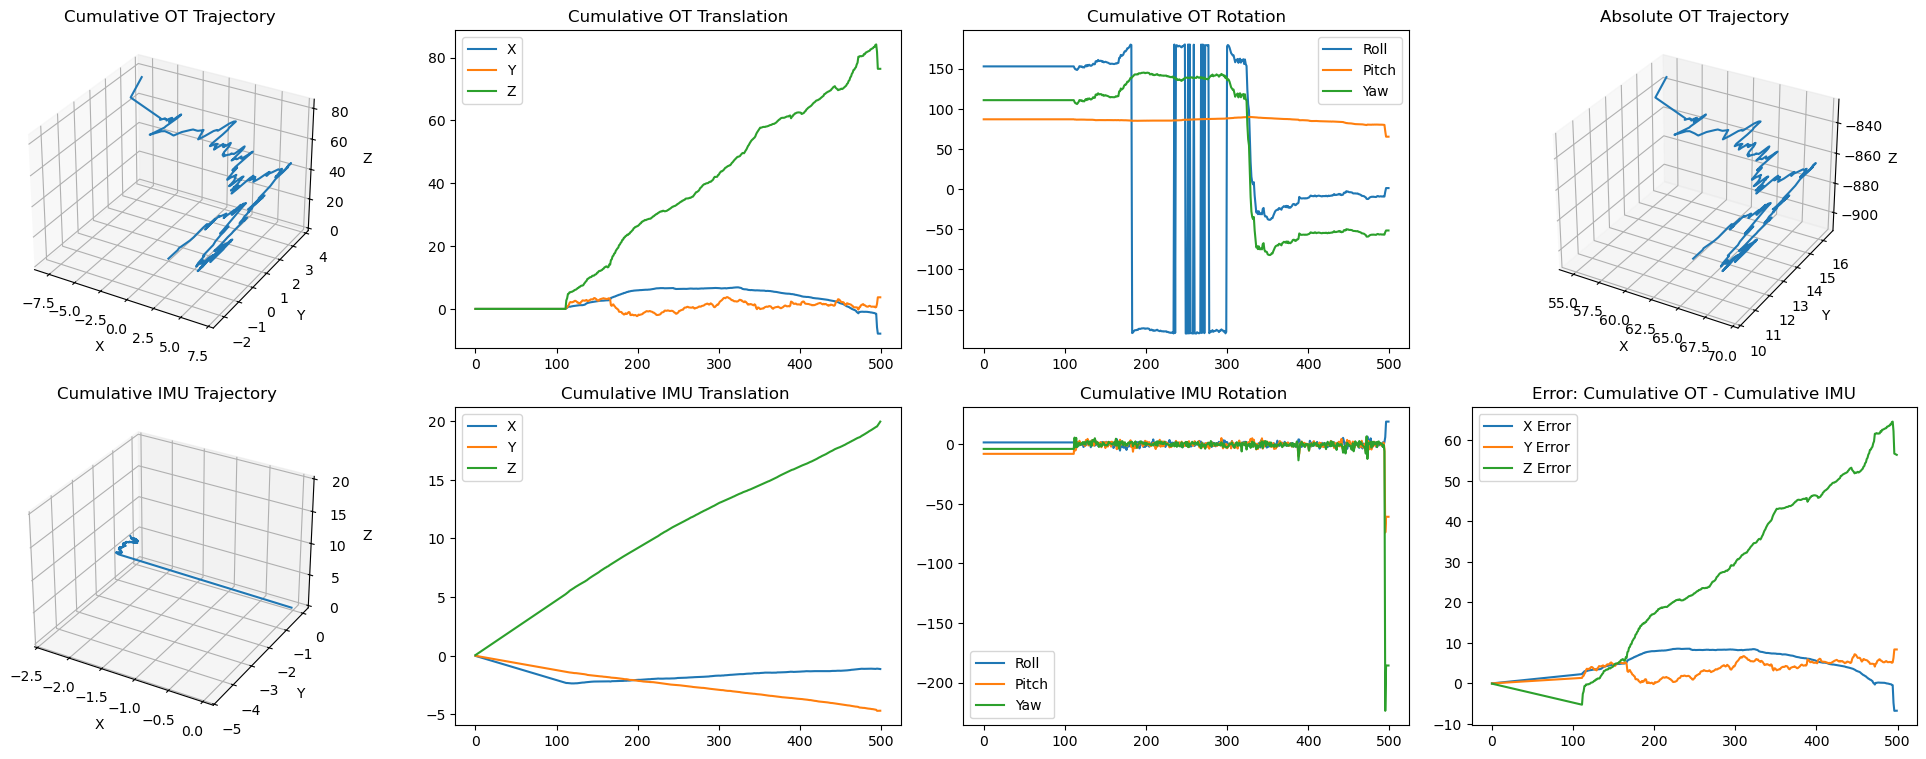

[09/12/24 14:10:21] INFO     INFO:rich:Loaded data from scans/wrist/wrist1_vs_2608.h5               ]8;id=425725;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=615171;file:///tmp/ipykernel_2075088/2834228533.py#6\6]8;;\

                    INFO     INFO:rich:columns: Index(['timestamp', 'frame', 'imu_acc_x',           ]8;id=193499;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=214698;file:///tmp/ipykernel_2075088/2834228533.py#7\7]8;;\
                             'imu_acc_y', 'imu_acc_z',                                                             
                                    'imu_orientation_x', 'imu_orientation_y', 'imu_orientation_z',                 
                                    'ot_pos_x', 'ot_pos_y', 'ot_pos_z', 'ot_qw', 'ot_qx', 'ot_qy',                 
                             'ot_qz',                                                                              
                                    'ot_cumulative_x', 'ot_cumulative_y', 'ot_cumulative_z',                       
                                    'ot_cumulative_rot_x', 'ot_cumulative_rot_y',                                  
                             'ot_cumulative_rot_z',                                                                
                                    'imu_cumulative_x', 'imu_cumulative_y', 'imu_cumulative_z'],                   
                                   dtype='object')                                                                 

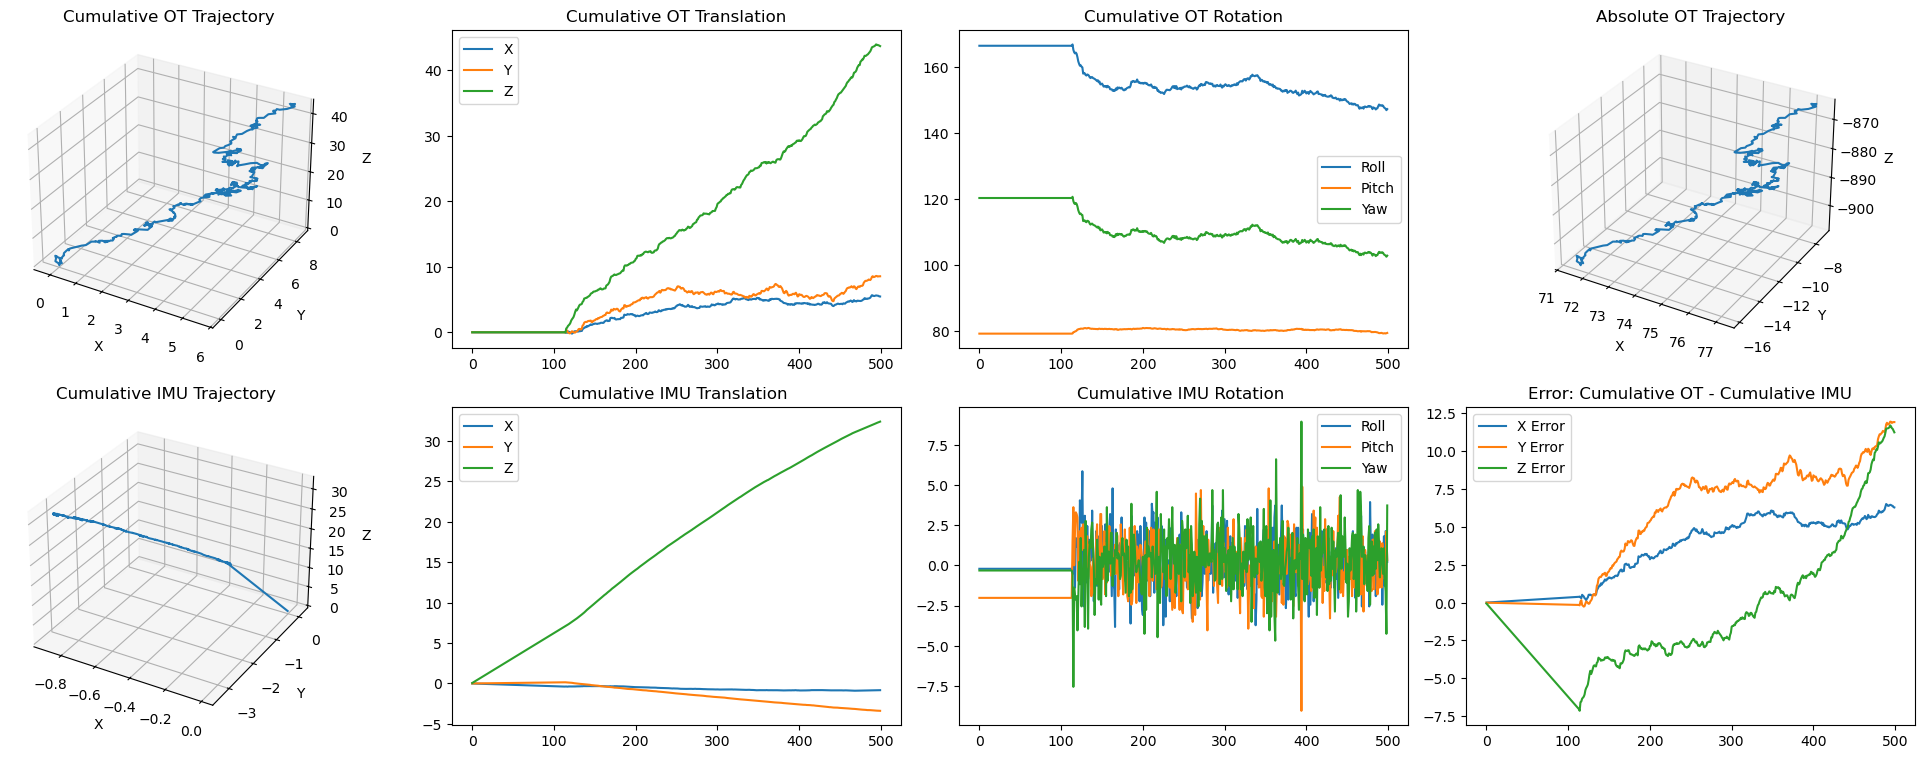

[09/12/24 14:10:24] INFO     INFO:rich:Loaded data from scans/wrist/wrist1_yx_2608.h5               ]8;id=36559;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=754882;file:///tmp/ipykernel_2075088/2834228533.py#6\6]8;;\

                    INFO     INFO:rich:columns: Index(['timestamp', 'frame', 'imu_acc_x',           ]8;id=285787;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=387862;file:///tmp/ipykernel_2075088/2834228533.py#7\7]8;;\
                             'imu_acc_y', 'imu_acc_z',                                                             
                                    'imu_orientation_x', 'imu_orientation_y', 'imu_orientation_z',                 
                                    'ot_pos_x', 'ot_pos_y', 'ot_pos_z', 'ot_qw', 'ot_qx', 'ot_qy',                 
                             'ot_qz',                                                                              
                                    'ot_cumulative_x', 'ot_cumulative_y', 'ot_cumulative_z',                       
                                    'ot_cumulative_rot_x', 'ot_cumulative_rot_y',                                  
                             'ot_cumulative_rot_z',                                                                
                                    'imu_cumulative_x', 'imu_cumulative_y', 'imu_cumulative_z'],                   
                                   dtype='object')                                                                 

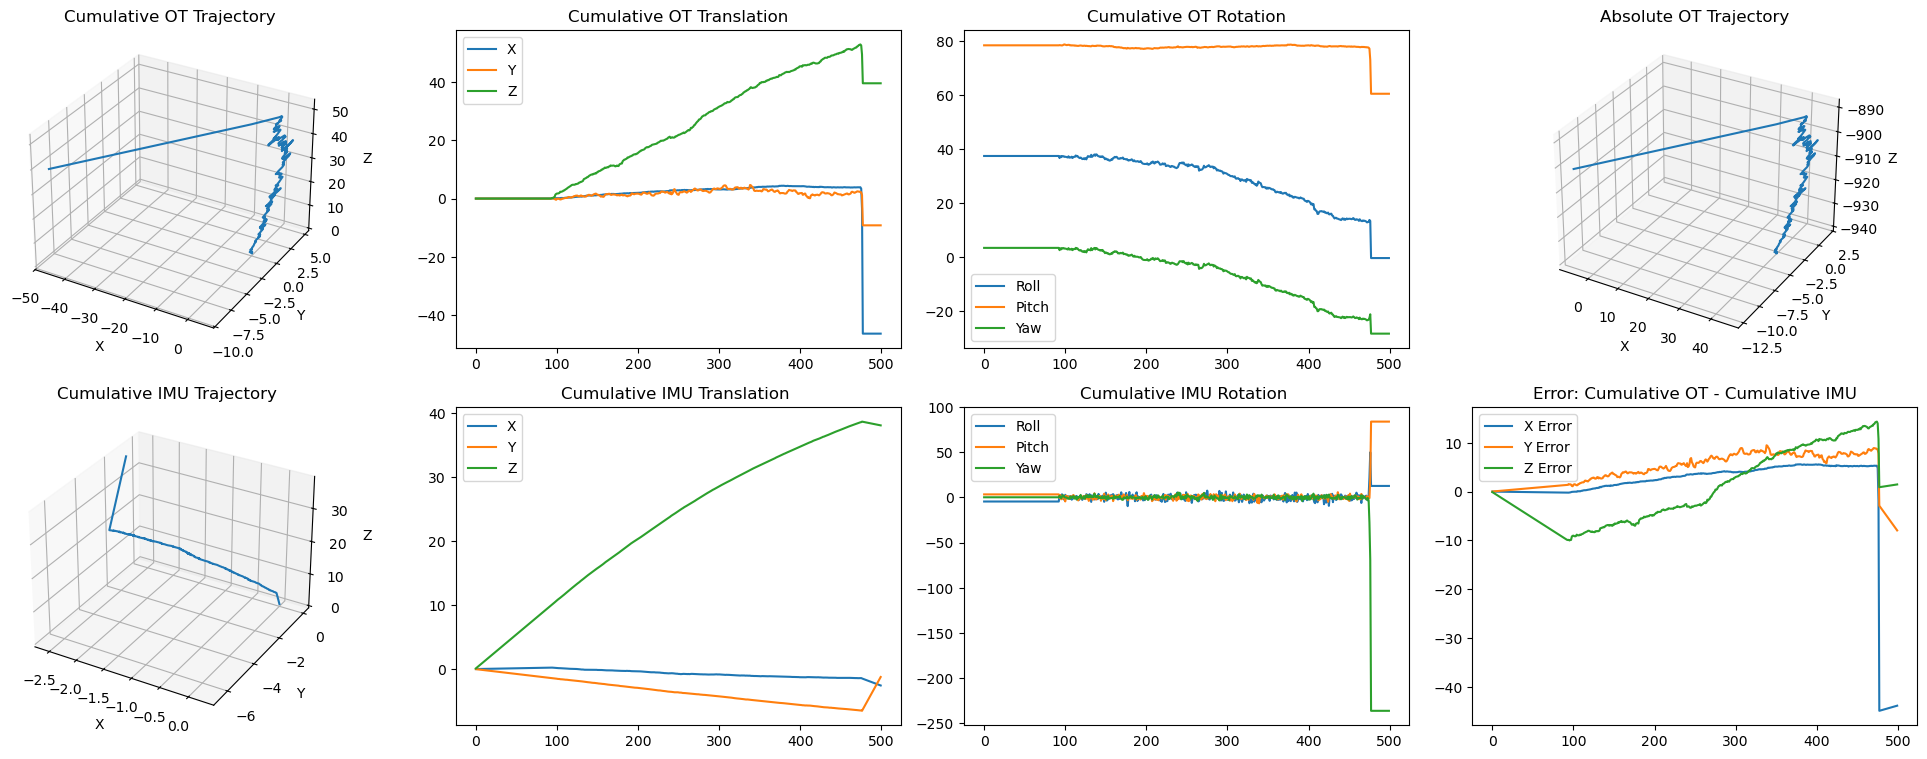

[09/12/24 14:10:28] INFO     INFO:rich:Loaded data from scans/wrist/wrist2_na_2608.h5               ]8;id=211615;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=435199;file:///tmp/ipykernel_2075088/2834228533.py#6\6]8;;\

                    INFO     INFO:rich:columns: Index(['timestamp', 'frame', 'imu_acc_x',           ]8;id=379308;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=11458;file:///tmp/ipykernel_2075088/2834228533.py#7\7]8;;\
                             'imu_acc_y', 'imu_acc_z',                                                             
                                    'imu_orientation_x', 'imu_orientation_y', 'imu_orientation_z',                 
                                    'ot_pos_x', 'ot_pos_y', 'ot_pos_z', 'ot_qw', 'ot_qx', 'ot_qy',                 
                             'ot_qz',                                                                              
                                    'ot_cumulative_x', 'ot_cumulative_y', 'ot_cumulative_z',                       
                                    'ot_cumulative_rot_x', 'ot_cumulative_rot_y',                                  
                             'ot_cumulative_rot_z',                                                                
                                    'imu_cumulative_x', 'imu_cumulative_y', 'imu_cumulative_z'],                   
                                   dtype='object')                                                                 

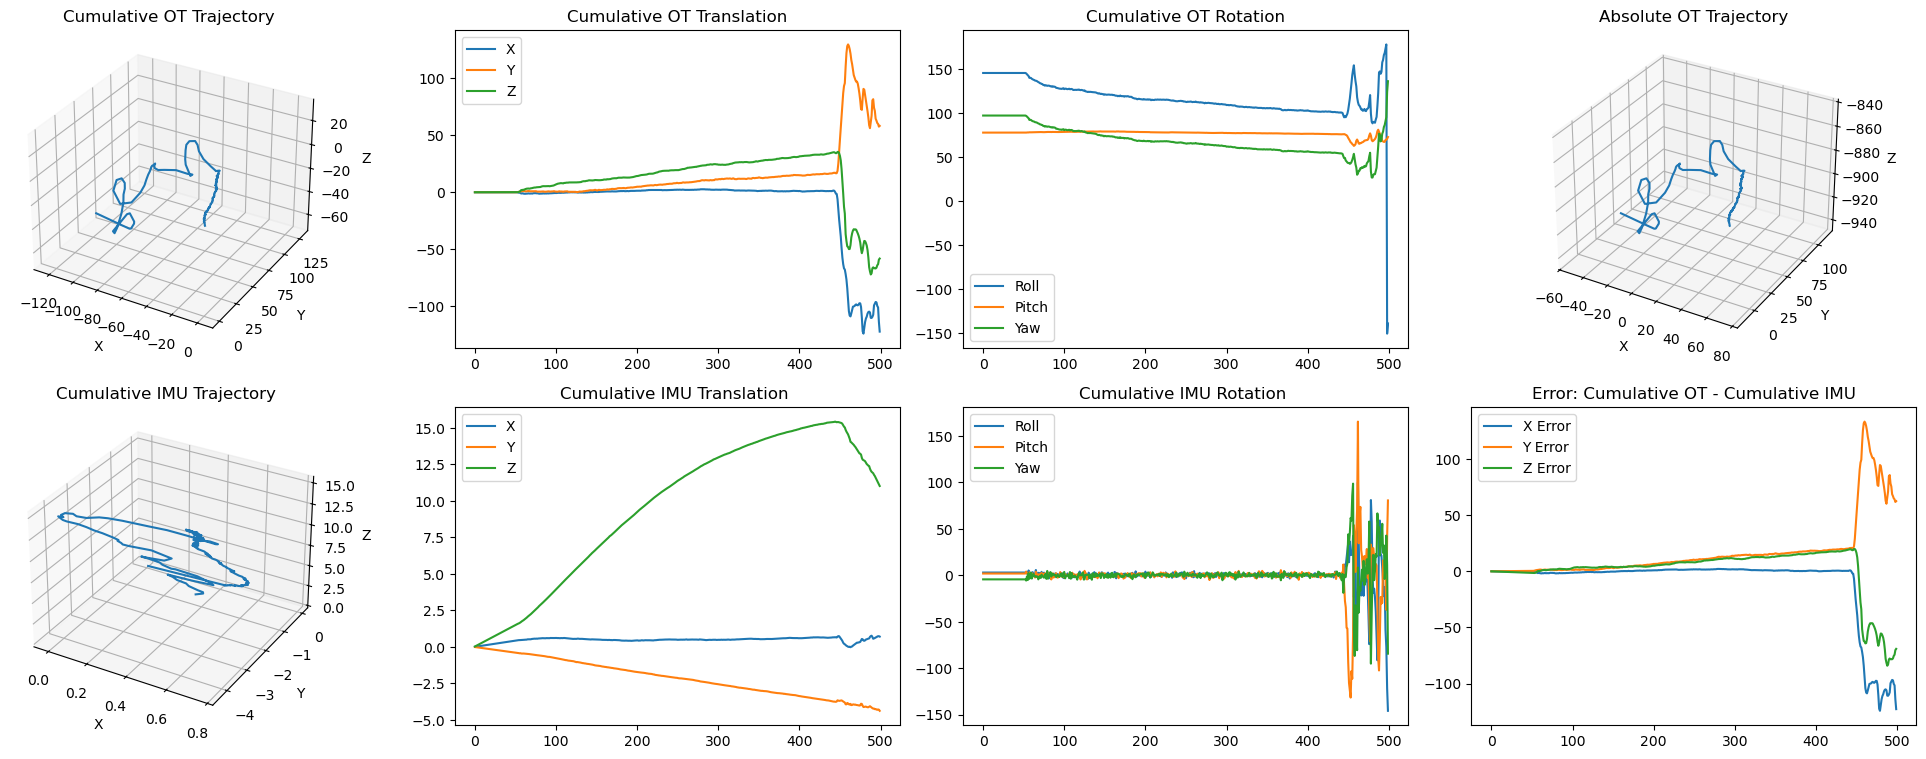

[09/12/24 14:10:31] INFO     INFO:rich:Loaded data from scans/wrist/wrist2_yx_2608.h5               ]8;id=886381;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=896089;file:///tmp/ipykernel_2075088/2834228533.py#6\6]8;;\

                    INFO     INFO:rich:columns: Index(['timestamp', 'frame', 'imu_acc_x',           ]8;id=305731;file:///tmp/ipykernel_2075088/2834228533.py\2834228533.py]8;;\:]8;id=609418;file:///tmp/ipykernel_2075088/2834228533.py#7\7]8;;\
                             'imu_acc_y', 'imu_acc_z',                                                             
                                    'imu_orientation_x', 'imu_orientation_y', 'imu_orientation_z',                 
                                    'ot_pos_x', 'ot_pos_y', 'ot_pos_z', 'ot_qw', 'ot_qx', 'ot_qy',                 
                             'ot_qz',                                                                              
                                    'ot_cumulative_x', 'ot_cumulative_y', 'ot_cumulative_z',                       
                                    'ot_cumulative_rot_x', 'ot_cumulative_rot_y',                                  
                             'ot_cumulative_rot_z',                                                                
                                    'imu_cumulative_x', 'imu_cumulative_y', 'imu_cumulative_z'],                   
                                   dtype='object')                                                                 

In [11]:
# Load and preprocess data
dfs = []
for path, df in tqdm(load_data(SCAN_DIR, align=IMU_ALIGN), desc="Loading Data"):
    visualize_trajectories_and_errors(df, IMU_ALIGN)
    dfs.append((path, df))
    logger.info(f"Loaded data from {path}")
    logger.info(f"columns: {df.columns}")
    logger.debug(f"df: {df}")

In [12]:
# Split the data into training, validation, and test sets
train_dataset, val_dataset, test_dataset, split_paths = split_dataset(
    dfs, val_size=VAL_SPLIT, test_size=TEST_SPLIT
)

[09/12/24 14:10:34] INFO     INFO:rich:Total files: 5                                             ]8;id=53926;file:///tmp/ipykernel_2075088/1105059061.py\1105059061.py]8;;\:]8;id=408784;file:///tmp/ipykernel_2075088/1105059061.py#162\162]8;;\

                    INFO     INFO:rich:Training files: 3, Validation files: 1, Test files: 1      ]8;id=544612;file:///tmp/ipykernel_2075088/1105059061.py\1105059061.py]8;;\:]8;id=187020;file:///tmp/ipykernel_2075088/1105059061.py#163\163]8;;\

In [13]:
temp_iter = iter(train_dataset)
counter = 0
while True:
    frames, imu_data, targets = next(temp_iter)
    if targets.abs().max() > 0:
        print(
            f"frames: {frames.shape}, imu_data: {imu_data.shape}, targets: {targets.shape}, counter: {counter}"
        )
        break
    counter += 1

frames: torch.Size([2, 3, 333, 219]), imu_data: torch.Size([2, 6]), targets: torch.Size([6]), counter: 0


In [14]:
# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    train_dataset, val_dataset, test_dataset, BATCH_SIZE_TRAIN, BATCH_SIZE_VAL
)

[09/12/24 14:11:51] INFO     INFO:rich:Training samples: 803, Validation samples: 281, Test       ]8;id=351527;file:///tmp/ipykernel_2075088/1105059061.py\1105059061.py]8;;\:]8;id=801363;file:///tmp/ipykernel_2075088/1105059061.py#193\193]8;;\
                             samples: 297                                                                          

In [15]:
# Initialize the IMUProcessor
imu_processor = IMUProcessor(input_dim=6, hidden_dim=64, output_dim=6).to(DEVICE)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(imu_processor.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.9, patience=3, verbose=True
)

# Training loop for the IMUProcessor with early stopping
train_imu_processor(
    imu_processor,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    patience=PATIENCE,
)

Epoch 1/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 finished. Train Loss: 117.0861, Val Loss: 93.4030
Epoch 2/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 finished. Train Loss: 84.2424, Val Loss: 68.1938
Epoch 3/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 finished. Train Loss: 92.1576, Val Loss: 50.4243
Epoch 4/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 finished. Train Loss: 63.9095, Val Loss: 37.0648
Epoch 5/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 finished. Train Loss: 46.1678, Val Loss: 38.2097
Epoch 6/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 finished. Train Loss: 52.2851, Val Loss: 30.7520
Epoch 7/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 finished. Train Loss: 42.5673, Val Loss: 30.8530
Epoch 8/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 finished. Train Loss: 41.5488, Val Loss: 29.3228
Epoch 9/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 finished. Train Loss: 39.0435, Val Loss: 28.5061
Epoch 10/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 finished. Train Loss: 36.8765, Val Loss: 27.9675
Epoch 11/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 finished. Train Loss: 35.1814, Val Loss: 27.2134
Epoch 12/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 finished. Train Loss: 33.4886, Val Loss: 26.4773
Epoch 13/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 finished. Train Loss: 31.9750, Val Loss: 25.4629
Epoch 14/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 finished. Train Loss: 32.5452, Val Loss: 24.1505
Epoch 15/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 finished. Train Loss: 30.0005, Val Loss: 23.4199
Epoch 16/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16 finished. Train Loss: 28.2475, Val Loss: 21.8556
Epoch 17/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17 finished. Train Loss: 26.3658, Val Loss: 20.8282
Epoch 18/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18 finished. Train Loss: 25.0160, Val Loss: 20.6108
Epoch 19/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19 finished. Train Loss: 24.0933, Val Loss: 21.0031
Epoch 20/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20 finished. Train Loss: 23.0815, Val Loss: 21.2582
Epoch 21/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21 finished. Train Loss: 22.2435, Val Loss: 21.7301
Epoch 22/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22 finished. Train Loss: 21.3667, Val Loss: 22.0654
Epoch 23/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23 finished. Train Loss: 20.5788, Val Loss: 22.3943
Epoch 24/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24 finished. Train Loss: 19.9873, Val Loss: 22.8021
Epoch 25/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25 finished. Train Loss: 19.1647, Val Loss: 23.1208
Epoch 26/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26 finished. Train Loss: 18.6991, Val Loss: 23.3580
Epoch 27/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27 finished. Train Loss: 18.3088, Val Loss: 23.7567
Epoch 28/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28 finished. Train Loss: 17.8804, Val Loss: 23.9725
Epoch 29/100000


Training:   0%|          | 0/13 [00:00<?, ?it/s]

In [16]:
# Inference and prediction
test_frames, test_predictions = inference_and_prediction(test_loader, imu_processor)

## 9. Visualization and Analysis


In [17]:
# Reconstruct ground truth volume
test_df = pd.read_hdf(split_paths["test"][0])

In [ ]:
test_df_preprocessed = preprocess_and_align_dataframe(test_df, align=IMU_ALIGN)
gt_volume, min_corner, voxel_size, gt_centers, gt_orientations = (
    reconstruct_ground_truth_volume(test_df_preprocessed, PROBE_SPECS)
)

In [ ]:
# Visualize ground truth volume
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(np.max(gt_volume, axis=0), cmap="gray")
plt.title("Ground Truth - XY Plane")
plt.subplot(132)
plt.imshow(np.max(gt_volume, axis=1), cmap="gray")
plt.title("Ground Truth - XZ Plane")
plt.subplot(133)
plt.imshow(np.max(gt_volume, axis=2), cmap="gray")
plt.title("Ground Truth - YZ Plane")
plt.tight_layout()
plt.show()

In [ ]:
# Reconstruct predicted volume
predicted_volume, pred_volume_origin, pred_voxel_size = (
    reconstruct_predicted_volume_displacement(
        test_frames[:, 0],
        test_predictions,
        PROBE_SPECS,
        voxel_size=RECONSTRUCTION_VOXEL_SIZE,
        ot_translation_scale=OT_TRANSLATION_SCALE,
        ot_rotation_scale=OT_ROTATION_SCALE,
        initial_pose=None,
    )
)

In [ ]:
# Visualize predicted volume
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(np.max(predicted_volume, axis=0), cmap="gray")
plt.title("Predicted - XY Plane")
plt.subplot(132)
plt.imshow(np.max(predicted_volume, axis=1), cmap="gray")
plt.title("Predicted - XZ Plane")
plt.subplot(133)
plt.imshow(np.max(predicted_volume, axis=2), cmap="gray")
plt.title("Predicted - YZ Plane")
plt.tight_layout()
plt.show()

In [ ]:
# Plot frame center trajectories
plot_frame_center_trajectories_with_error(
    gt_centers[: -(SEQUENCE_LENGTH - 1), :],
    gt_orientations[: -(SEQUENCE_LENGTH - 1), :],
    test_predictions[:, :3],
    test_predictions[:, 3:],
    frame_stride=1,
    scale=0,
)

In [ ]:
# Save results
np.save("test_predictions.npy", test_predictions)
np.save("test_frames.npy", test_frames)
np.save("ground_truth_volume.npy", ground_truth_volume)
np.save("predicted_volume.npy", predicted_volume)
print("Results saved as .npy files")

In [ ]:
# Print summary statistics
print("Prediction Summary Statistics:")
print(pd.DataFrame(test_predictions).describe())